# Analyzing correlations betweeen variables in IndividualProjectDataset_by_customerID_joined_prepared_prepared

In this notebook, we are going to study the correlations.

* [Setup and loading the data](#setup)
* [Correlation matrix](#corr-matrix)
* [Scatterplot matrix](#scatter-matrix)
* [Detailed analysis between two variables](#two-vars)

<center><strong>Select Cell > Run All to execute the whole analysis</strong></center>

## Setup and dataset loading <a id="setup" /> 

First of all, let's load the libraries that we'll use

In [1]:
%pylab inline
import dataiku                          # Access to Dataiku datasets
import pandas as pd, numpy as np        # Data manipulation 
import scipy.cluster.hierarchy as sch   # Used for reordering the correlation matrix
import seaborn as sns                   # Graphing
sns.set(style="white")                  # Tuning the style of charts
import warnings                         # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Populating the interactive namespace from numpy and matplotlib


The first thing we do is now to load the dataset and put aside the three main types of columns:

* Numerics
* Categorical
* Dates

Since analyzing correlations requires to have the data in memory, we are only going to load a sample of the data. Modify the following cell to change the size of the sample.

In [2]:
# Take a handle on the dataset
mydataset = dataiku.Dataset("IndividualProjectDataset_by_customerID_joined_prepared_prepared")

# Load the first 100'000 lines.
# You can also load random samples, limit yourself to some columns, or only load
# data matching some filters.
#
# Please refer to the Dataiku Python API documentation for more information
df = mydataset.get_dataframe(
    limit = 100000)

# Get the column names
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
categorical_columns = list(df.select_dtypes(include=[object]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

# Print a quick summary of what we just loaded
print "Loaded dataset"
print "   Rows: %s" % df.shape[0]
print "   Columns: %s (%s num, %s cat, %s date)" % (df.shape[1], 
                                                    len(numerical_columns), len(categorical_columns),
                                                    len(date_columns))

Loaded dataset
   Rows: 100000
   Columns: 50 (49 num, 1 cat, 0 date)


# Correlation matrix <a id="corr-matrix" />

The very first correlation analysis consists of plotting the "Correlation matrix" for numerical variables.

For each couple of numerical variables, this computes the "strength" of the correlation (called the Pearson coefficient):

 * 1.0 means a perfect correlation
 * 0.0 means no correlation
 * -1.0 means a perfect "inverse" correlation
 
Since it does not really make sense to print this correlation plot for hundred of variables, we are restricting it to the first 50 numerical variables of the dataset. Modify the following cell to change this

In [3]:
# Select variables to plot for the correlation matrix
corr_matrix_vars = numerical_columns[0:50]

print "Plotting the correlation matrix on the following variables : %s" % corr_matrix_vars

Plotting the correlation matrix on the following variables : [u'gender', u'marital_single', u'marital_married', u'marital_widower', u'marital_divorced', u'age_36 : 54', u'age_54 : 72', u'age_72 : 90', u'age_18 : 36', u'ext_score', u'guarantor', u'public_debt', u'delinquency_list', u'sub_par', u'salary_[2000,3000]', u'salary_[1000,1300]', u'salary_[1500,2000]', u'salary_[3000,5000]', u'salary_[650,1000]', u'salary_[1300,1500]', u'salary_[0,650]', u'salary_[5000,8000]', u'salary_[8000,]', u'loans_3 : 4', u'loans_0 : 1', u'loans_1 : 2', u'loans_-1 : 0', u'loans_4 : 5', u'loans_2 : 3', u'loans_7 : 8', u'loans_5 : 6', u'loans_6 : 7', u'mortgages_0 : 1', u'mortgages_-1 : 0', u'mortgages_1 : 2', u'mortgages_2 : 3', u'channel_branch', u'channel_call center', u'channel_recovery', u'channel_app', u'channel_external agent', u'channel_online', u'subsidized_housing', u'prior_loan_normal', u'prior_loan_restructuring', u'prior_loan_unpaid', u'prior_loan_refinancing', u'prior_loan_default', u'credit_p

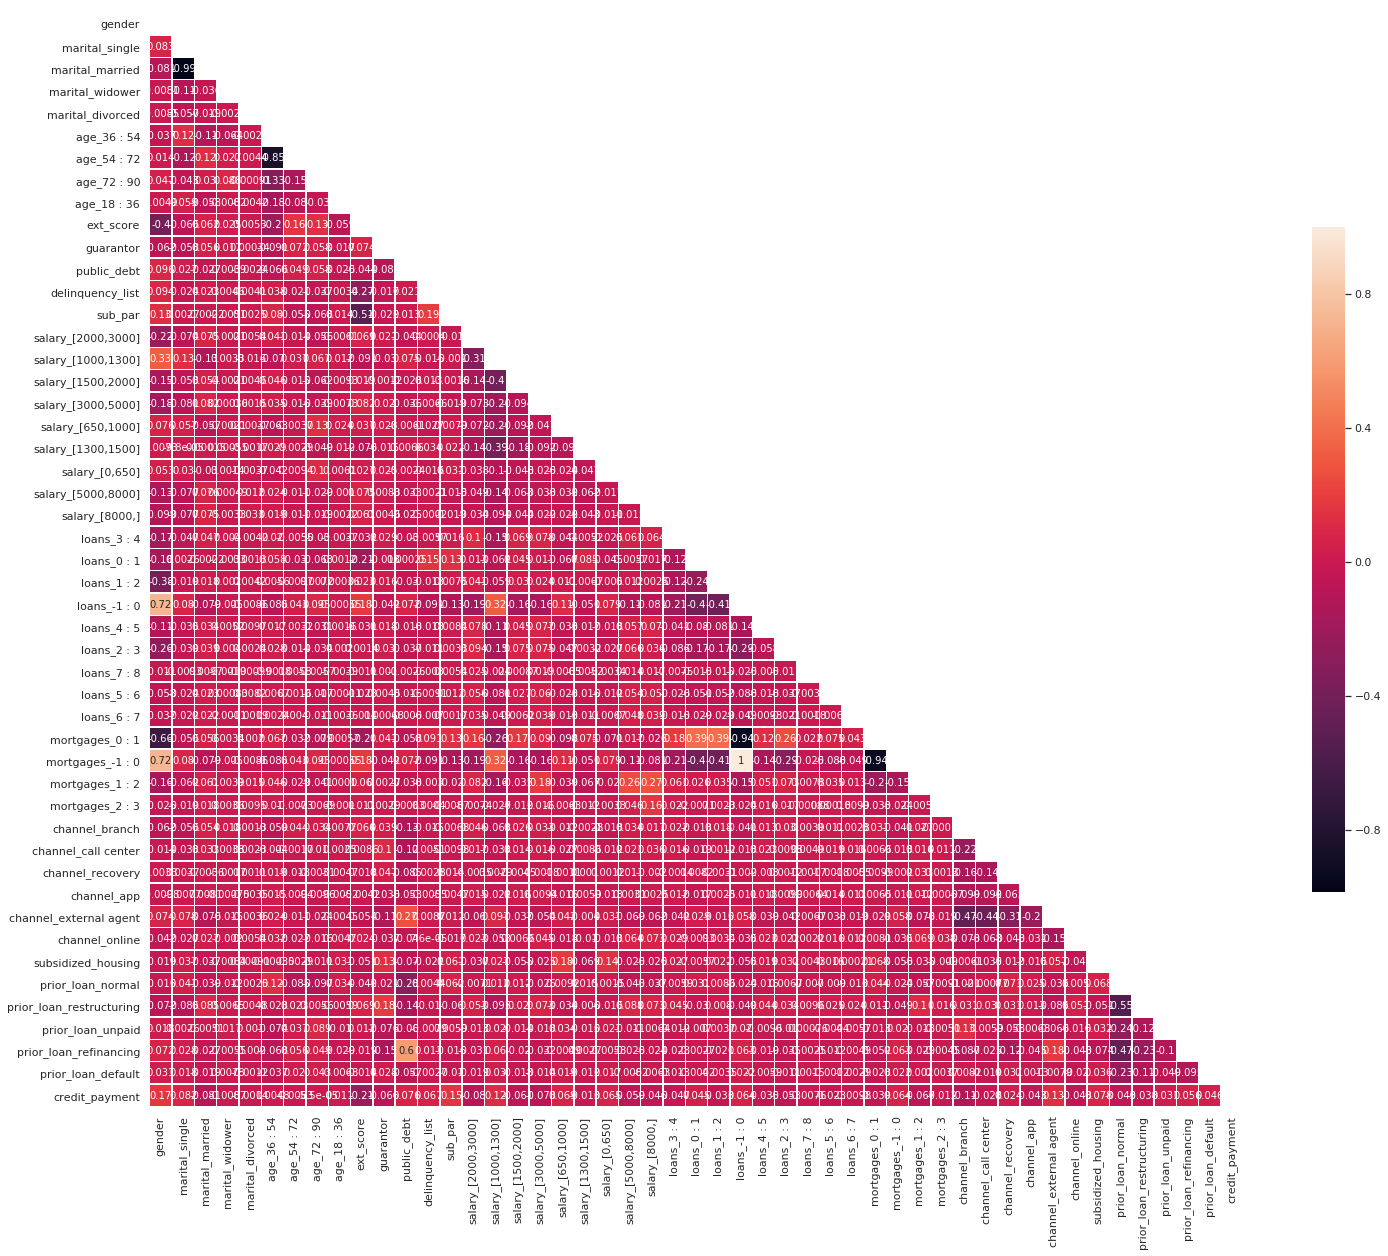

In [4]:
# Only select the requested columns
df_corr_matrix = df[corr_matrix_vars]

# This computes the Pearson coefficient for all couples
corr = df_corr_matrix.corr().fillna(0)

# Start drawing

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
size = max(10, len(corr.columns)/2.)
f, ax = plt.subplots(figsize=(size, size))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": 0.5}, ax=ax, annot = True)

### Reordered correlation matrix

An interesting improvement over the correlation matrix is to reorder it by similarity between the variables so that the "groups" of variables that are strongly correlated appear close in the matrix.

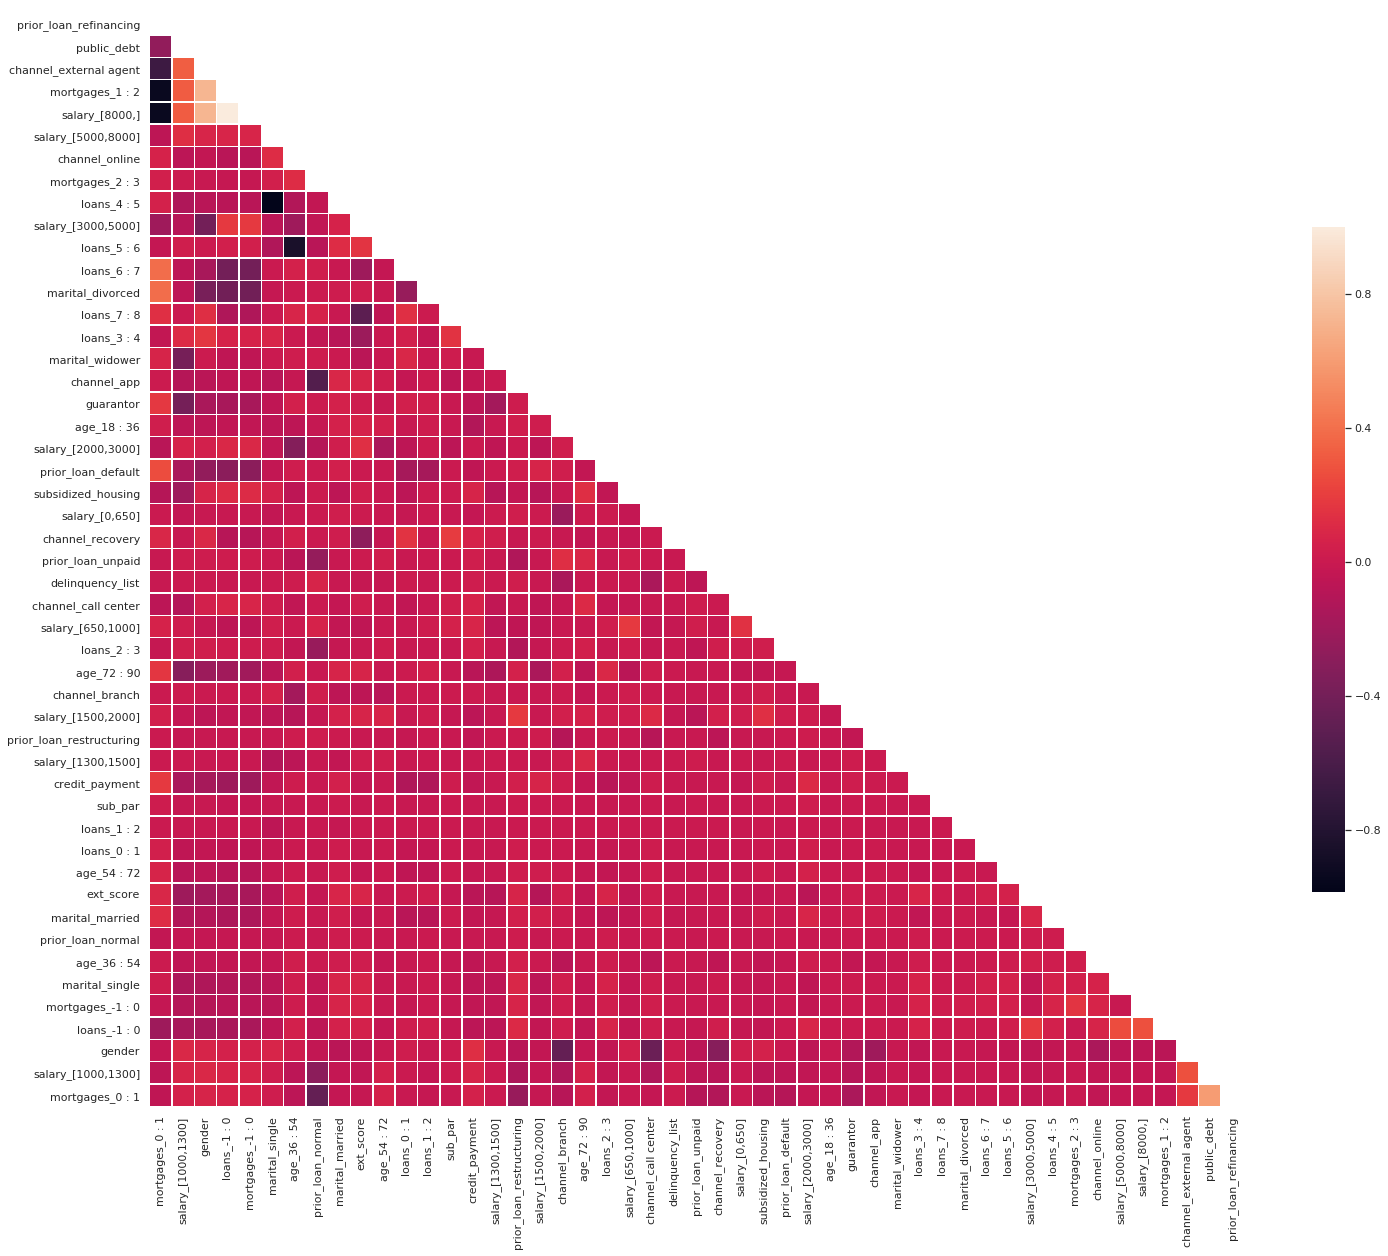

In [5]:
# Generate features and distance matrix.
D = corr.values
# Compute and plot dendrogram.
Y = sch.linkage(D, method='centroid')
Z = sch.dendrogram(Y, orientation='right',no_plot=True)
# Compute distance matrix.
index = Z['leaves']
D = D[index,:]
D = D[:,index]

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
size = max(10, len(corr.columns)/2.)
f, ax = plt.subplots(figsize=(size, size))

# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(D, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": 0.5}, ax=ax)
#ax.set(xticks=range(len(corr.columns)), xticklabels=corr.columns[index], yticks=range(len(corr.columns)), yticklabels=reversed(corr.columns[index]))
ax.set_xticklabels(corr.columns[index], rotation=90, ha='center');
ax.set_yticklabels(reversed(corr.columns[index]), rotation=0);

# Scatter matrices <a id="scatter-matrix" />

In [6]:
# Only generate the scatterplot matrix on a sample
df_scatter_samp = df.sample(min(5000, df.shape[0])) # 5000 points maximum on the scatter plot

# Take the first 4 numerical variables to plot the scatterplot matrix
scatter_matrix_vars = numerical_columns[0:4]

# If we have categorical variables, use the categorical variables with the lowest number of modalities
# to plot the points of the scatterplot
scatter_matrix_color = None

cat_cols_with_cards = [(x, df[x].nunique()) for x in categorical_columns]
# We don't want to take a column with only a single modality
# and also we don't want variables with more than 10 modalities (would not really make sense to plot)
cat_cols_with_cards_f = [x for x in cat_cols_with_cards if x[1] >= 2 and x[1] <= 10]

if len(cat_cols_with_cards_f) > 0:
    # We have at least one categorical variable with a good number of modalities, use it
    scatter_matrix_color = sorted(cat_cols_with_cards_f, key= lambda c : c[1])[0][0]
    
print "We will plot the following numerical variables : %s" % scatter_matrix_vars
if scatter_matrix_color is not None:
    print "Coloring the scatters by: %s" % scatter_matrix_color

We will plot the following numerical variables : [u'gender', u'marital_single', u'marital_married', u'marital_widower']


In [7]:
# Uncomment this if you want to take manual control over which variables are plotted
# scatter_matrix_vars = ["num1", "num2", "num3"]
# scatter_matrix_color = "cat1"

/home/dataiku/dataiku-dss-5.1.2/python.packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


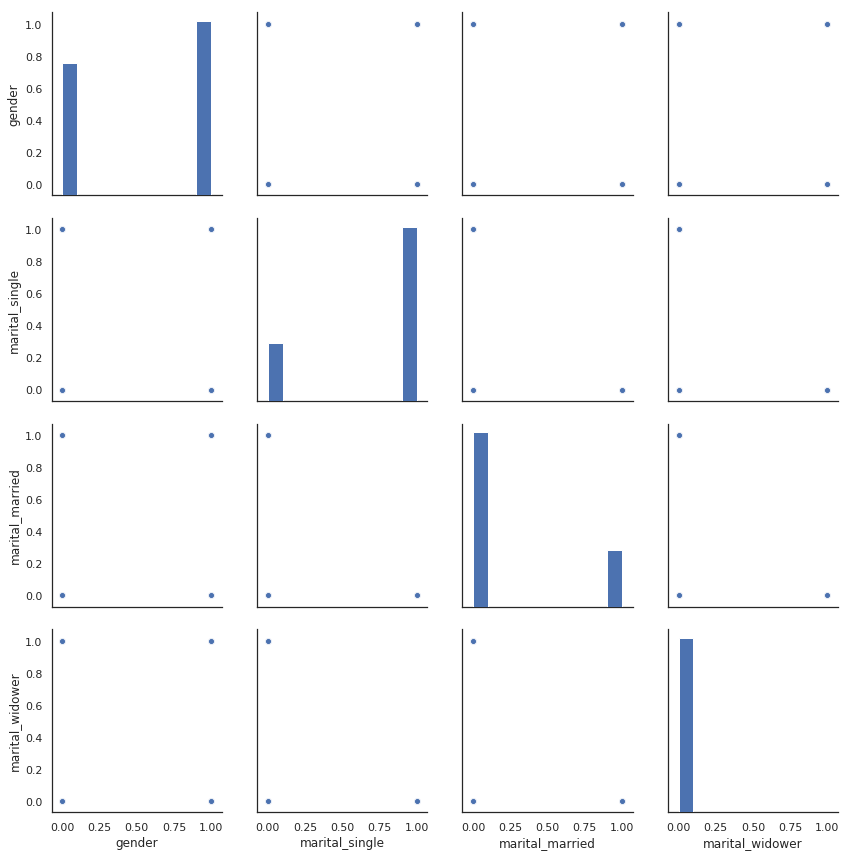

In [8]:
# Seaborn (the graphic library) doesn't like NaNs, so fill the matrix
df_filled = df.fillna(0)
sns.pairplot(df_filled, vars = scatter_matrix_vars, hue=scatter_matrix_color, size=3, palette="husl")

## See the relation between two features, including categorical features <a id="two-vars" />

In [9]:
# Compute cardinalities of our categorical variables
cat_cols_with_cards = [(x, df[x].nunique()) for x in categorical_columns]

# For proper display, we only want columns with modalities between 2 and 10
cat_cols_with_cards_f = [x for x in cat_cols_with_cards if x[1] >= 2 and x[1] <= 10]

nb_suitable_cats = len(cat_cols_with_cards_f)
nb_num = len(numerical_columns)

if nb_suitable_cats >= 1 and nb_num >= 1:
    tf_feat1 = cat_cols_with_cards_f[0][0]
    tf_feat2 = numerical_columns[0]

elif nb_suitable_cats == 0 and nb_num >= 2:
    tf_feat1 = numerical_columns[0]
    tf_feat2 = numerical_columns[1]

else:
    raise ValueError("Failed to automatically select proper variables to plot, please select manually")

print "Will plot relation between these two features: '%s' and '%s'" % (tf_feat1, tf_feat2)

Will plot relation between these two features: 'gender' and 'marital_single'


In [10]:
# Uncomment this to take control on the two variables
# tf_feat1 = "my_feat_1"
# tf_feat2 = "my_feat_2"

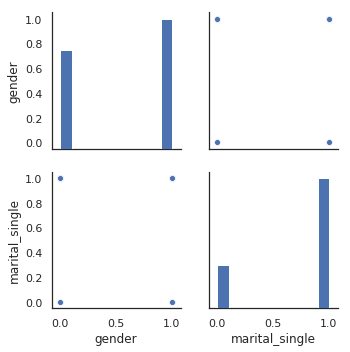

In [11]:
if tf_feat1 in numerical_columns and tf_feat2 in numerical_columns:
    sns.pairplot(df[[tf_feat1, tf_feat2]])
    
if tf_feat1 in numerical_columns and tf_feat2 in categorical_columns:
    sns.FacetGrid(df, col=tf_feat2, col_wrap=5, hue=None).map(sns.distplot, tf_feat1)
    
if tf_feat1 in categorical_columns and tf_feat2 in numerical_columns:
    sns.FacetGrid(df, col=tf_feat1, col_wrap=5, hue=None).map(sns.distplot, tf_feat2)
    
if tf_feat1 in categorical_columns and tf_feat2 in categorical_columns:
    tf_list = [tf_feat1, tf_feat2]
    tf_unique_count = [df[feat].unique().__len__() for feat in tf_list]
    tf_min_loc = tf_unique_count.index(min(tf_unique_count))
    sns.FacetGrid(data=df, col=tf_list[tf_min_loc], col_wrap=5, hue=None).map(sns.countplot, tf_list[(tf_min_loc+1)%2], order=df[tf_list[(tf_min_loc+1)%2]].unique())